In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import numpy as np

# Add the absolute path to the src directory to sys.path
src_path = os.path.abspath(os.path.join("..", "src"))
if src_path not in sys.path:
    sys.path.append(src_path)


# Visualize the orderbook over time

In [8]:
# Import functions and libraries
from src.francis.orderbook_plot import plot_orderbook_over_time
from src.francis.orderbook_reconstruction import reconstruct_orderbook_every_tick_with_orders
import pandas as pd
import json

In [25]:
# Reconstruct the orderbook
# Reload the uploaded original CSV file
file_path = "data/orderbook_data.csv"
df = pd.read_csv(file_path, header=None)

# Assign column names
df.columns = ["timestamp", "side", "price", "size", "number_of_orders"]
df = df[df["side"].isin(["bid", "ask"])]
df["timestamp"] = df["timestamp"].astype(float)
df["price"] = df["price"].astype(float)
df["size"] = df["size"].astype(float)

# Sort by timestamp
df = df.sort_values(by="timestamp")


# The original data is too large to visualize, so we take a sample
df_small = df.head(1000000)
sample_orderbook, sample_csv_rows = reconstruct_orderbook_every_tick_with_orders(
    df_small
)

# Save the result to JSON
sample_json_path = "data/reconstructed_orderbook_small.json"
with open(sample_json_path, "w") as f:
    json.dump(sample_orderbook, f)

# Save the result to CSV
sample_df = pd.DataFrame(
    sample_csv_rows, columns=["timestamp", "side", "price", "size", "number_of_orders"]
)

sample_df.to_csv("data/reconstructed_orderbook_small.csv", index=False)




/var/folders/db/919qzgb17qx_tyqb0qbkngmm0000gn/T/ipykernel_35043/25472299.py:4: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, header=None)


In [6]:
import pandas as pd

# Reload the uploaded original CSV file, letting pandas pick up the header row
file_path = "data/orderbook_data.csv"
df = pd.read_csv(
    file_path,
    header=0,  # ← use the first line as column names
    dtype={"side": str, "price": float, "size": float, "number_of_orders": int}
)

# Keep only bids & asks
df = df[df["side"].isin(["bid", "ask"])]

# Convert UNIX seconds to datetime and index
df["timestamp"] = pd.to_datetime(df["timestamp"].astype(float), unit="s")
df = df.set_index("timestamp").sort_index()

# Resample into 1‑time bins
bids = (
    df[df["side"] == "bid"]
    .resample("1S")
    .agg(
        bid_orders=("number_of_orders", "sum"),
        best_bid=("price", "max")
    )
)
asks = (
    df[df["side"] == "ask"]
    .resample("1S")
    .agg(
        ask_orders=("number_of_orders", "sum"),
        best_ask=("price", "min")
    )
)

# Combine and compute mid‑price
per_time = pd.concat([bids, asks], axis=1)
per_time["mid_price"] = (per_time["best_bid"] + per_time["best_ask"]) / 2
per_time = per_time.dropna(subset=["mid_price"])  # drop any time missing one side

# Write out to CSV
per_time.to_csv("data/reconstructed_orderbook_by_time.csv", index_label="timestamp")


/var/folders/db/919qzgb17qx_tyqb0qbkngmm0000gn/T/ipykernel_37019/1178261975.py:21: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .resample("1S")
/var/folders/db/919qzgb17qx_tyqb0qbkngmm0000gn/T/ipykernel_37019/1178261975.py:29: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .resample("1S")


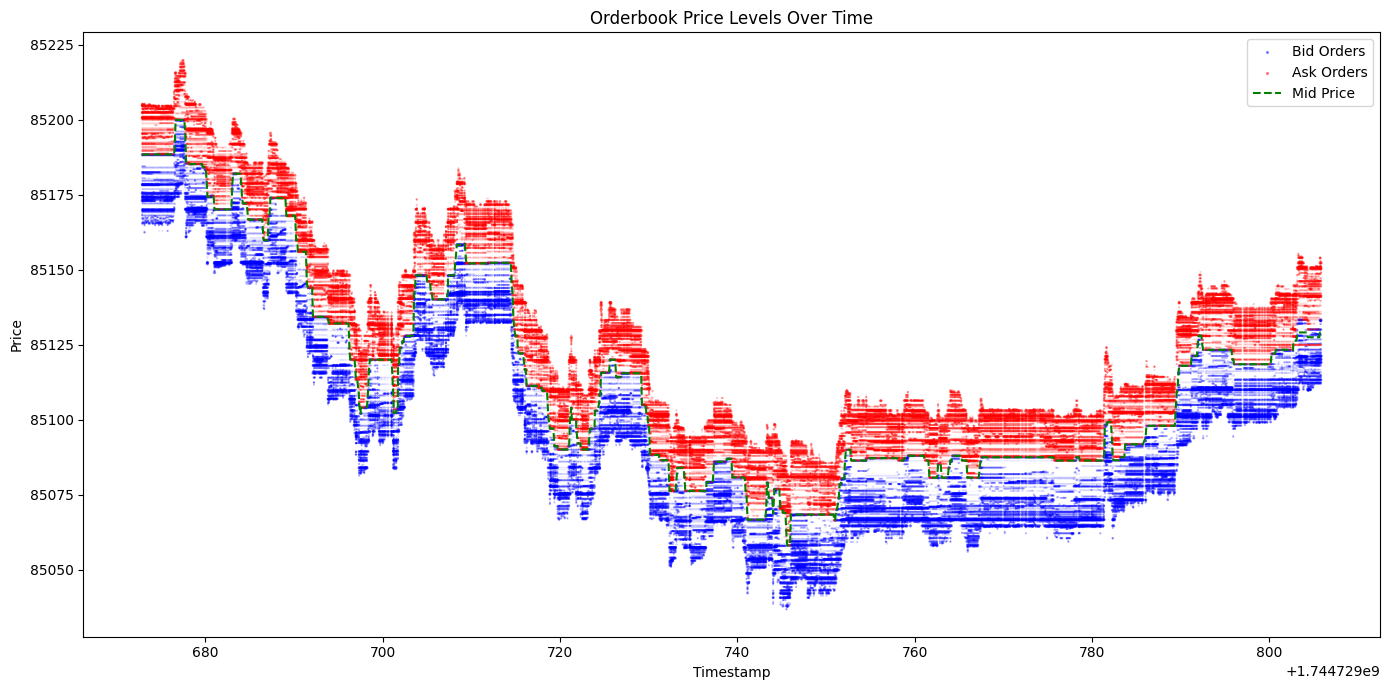

In [9]:

orderbook = pd.read_csv("data/reconstructed_orderbook_small.csv")
plot_orderbook_over_time(orderbook)


In [6]:
book = oba.loadReconstructedOrderbook("data/reconstructed_orderbook_by_time.csv")
print(book.index.min(), "→", book.index.max())
print("Total seconds:", (book.index.max() - book.index.min()).total_seconds())


2025-04-15 15:07:52 → 2025-04-15 16:16:30
Total seconds: 4118.0


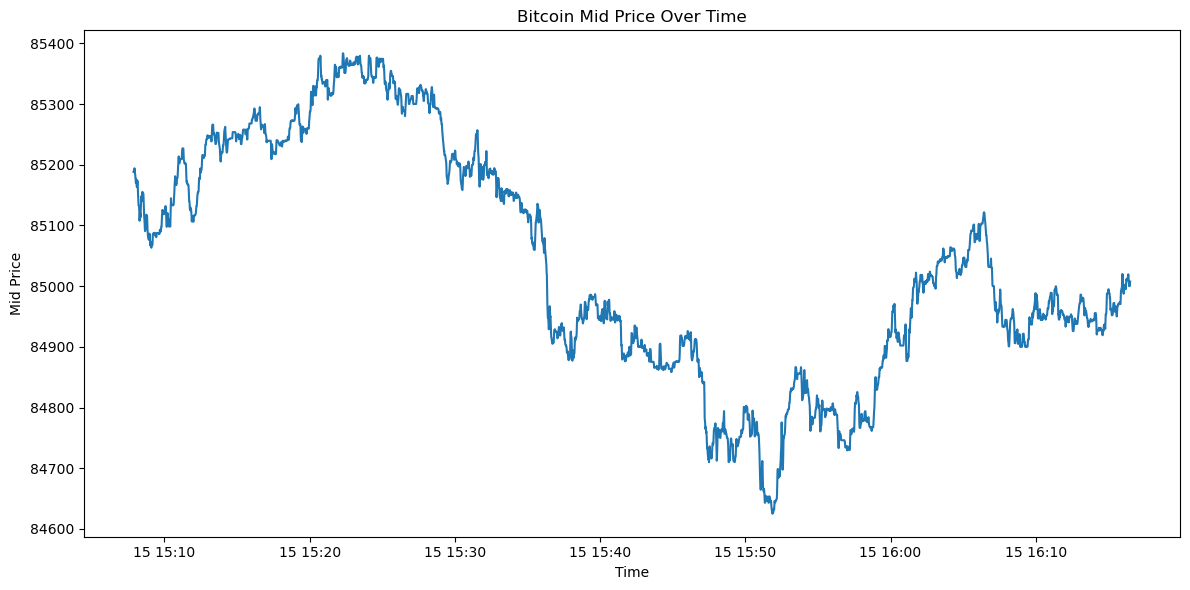

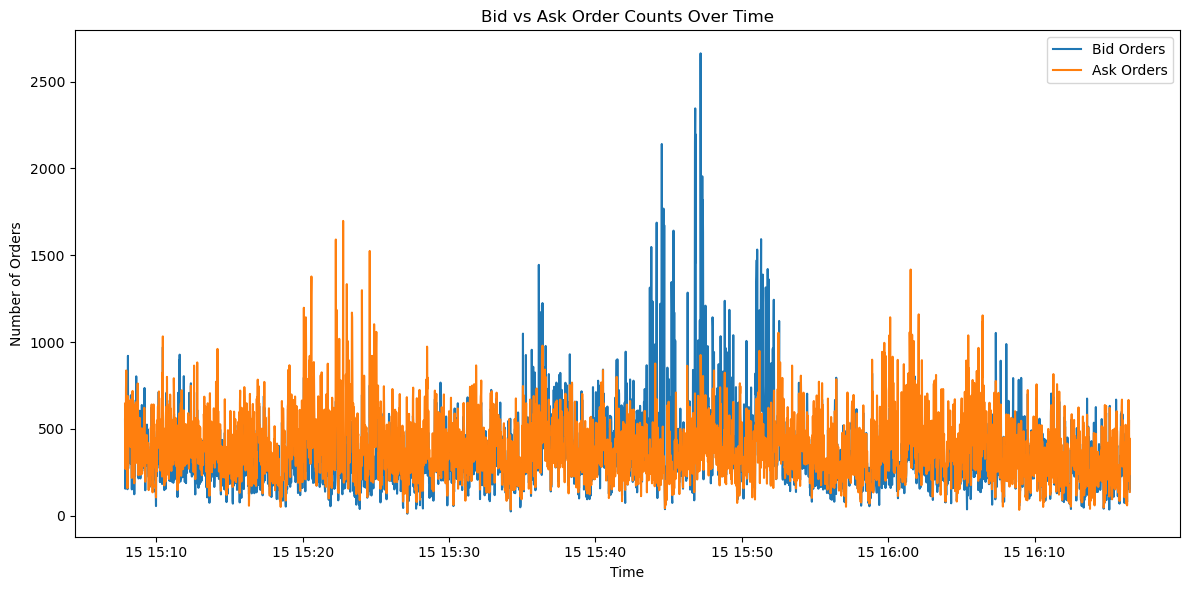

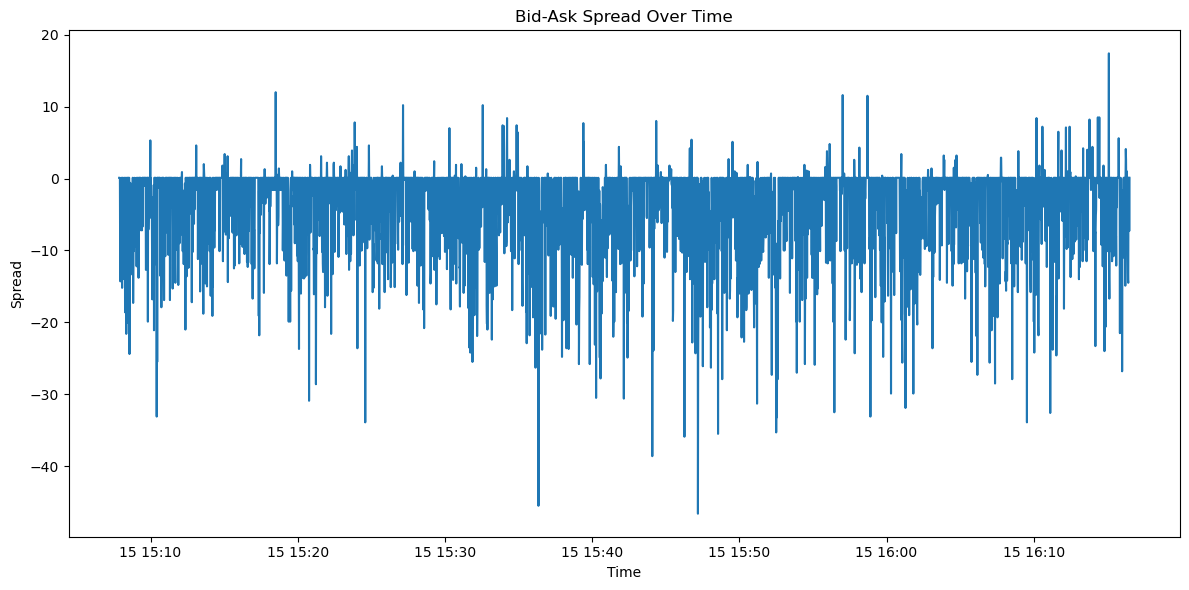

             startTime             endTime  drop_amount
0  2025-04-15 15:08:32 2025-04-15 15:08:37        41.35
1  2025-04-15 15:31:32 2025-04-15 15:31:37        40.85
2  2025-04-15 15:31:33 2025-04-15 15:31:38        41.05
3  2025-04-15 15:31:34 2025-04-15 15:31:39        43.05
4  2025-04-15 15:31:35 2025-04-15 15:31:40        43.90
..                 ...                 ...          ...
56 2025-04-15 16:01:02 2025-04-15 16:01:07        48.65
57 2025-04-15 16:01:45 2025-04-15 16:01:50        41.10
58 2025-04-15 16:01:46 2025-04-15 16:01:51        39.35
59 2025-04-15 16:08:28 2025-04-15 16:08:33        40.00
60 2025-04-15 16:11:30 2025-04-15 16:11:35        40.60

[61 rows x 3 columns]


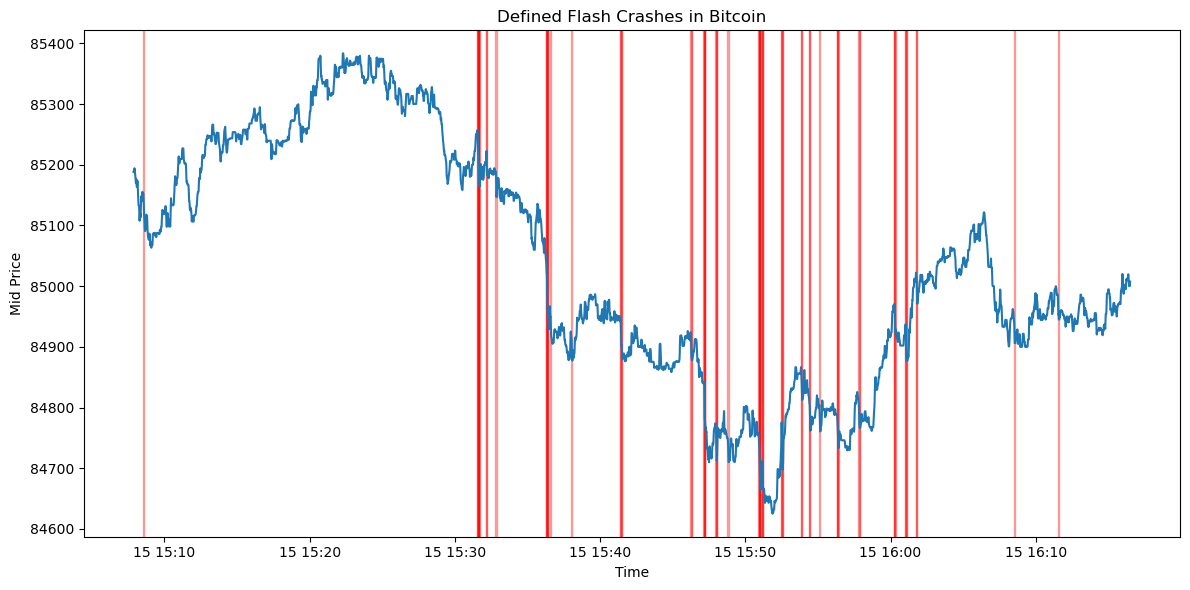

In [7]:
from src.tim import orderbook_analysis as oba

# load the per-second file
book = oba.loadReconstructedOrderbook("data/reconstructed_orderbook_by_time.csv")

# visualize
oba.plotMidPrice(book)
oba.plotOrderCounts(book)
oba.plotSpread(book)

# rolling 5‑second crash detection
crashes = oba.detectFlashCrashesRolling(book,
                                        thresholdRangePct=0.05,
                                        windowSeconds=5)
print(crashes)
oba.plotFlashCrashes(book, crashes)


# Label the Training Data
Since our goal is to predict the crash, we need to label the training data as 1, -1 if the large move happens, and 0 otherwise.







In [10]:
from src.francis.label_data_n_horizon import prepare_training_data_fullbook_future_label
from src.francis.label_data_full_book import prepare_training_data_full_book
from src.francis.label_data_partial_book import prepare_training_data_partial_book
from src.francis.mid_price_extract import extract_mid_prices

In [11]:
mid_df = extract_mid_prices("data/reconstructed_orderbook_small.csv")
mid_df.to_csv("data/mid_price_small.csv", index=False)

In [12]:
df = prepare_training_data_full_book(orderbook_csv="data/reconstructed_orderbook_small.csv",
                                      mid_price_csv="data/mid_price_small.csv",
                                      threshold=0.00002)


df.to_csv("data/training_data_full_book_small.csv", index=False)


In [13]:
df = prepare_training_data_partial_book(orderbook_csv="data/reconstructed_orderbook_small.csv",
                                      mid_price_csv="data/mid_price_small.csv",
                                      threshold=0.00002,
                                      top_n=5)


df.to_csv("data/training_data_partial_book_small.csv", index=False)



In [14]:
df = prepare_training_data_fullbook_future_label(orderbook_csv="data/reconstructed_orderbook_small.csv",
                                      mid_price_csv="data/mid_price_small.csv",
                                      threshold=0.00005,
                                      horizon=20)


df.to_csv("data/training_data_fullbook_future_label_small.csv", index=False)


🧾 Dataset Info
Rows: 1304  |  Columns: 4
Column Types:
timestamp    float64
bids          object
asks          object
label        float64
dtype: object
--------------------------------------------------
📅 Timestamp Range
From 1744729672.889366 to 1744729805.733907
--------------------------------------------------
📊 Label Distribution
label
-1.0    441
 1.0    433
 0.0    430
Name: count, dtype: int64
--------------------------------------------------
Orderbook Depth
Avg # of bids: 50.00  |  Max: 50
Avg # of asks: 50.00  |  Max: 50
--------------------------------------------------


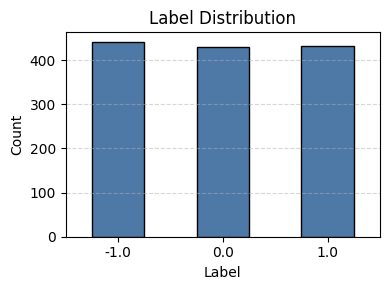

In [20]:

# Basic Info
import ast


print("🧾 Dataset Info")
print(f"Rows: {df.shape[0]}  |  Columns: {df.shape[1]}")
print("Column Types:")
print(df.dtypes)
print("-" * 50)

# Timestamp Range
print("📅 Timestamp Range")
print(f"From {df['timestamp'].min()} to {df['timestamp'].max()}")
print("-" * 50)

# Label Distribution
print("📊 Label Distribution")
print(df["label"].value_counts(dropna=False))
print("-" * 50)

# Orderbook Depth
bid_lens = df["bids"].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else len(x))
ask_lens = df["asks"].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else len(x))

print("Orderbook Depth")
print(f"Avg # of bids: {bid_lens.mean():.2f}  |  Max: {bid_lens.max()}")
print(f"Avg # of asks: {ask_lens.mean():.2f}  |  Max: {ask_lens.max()}")
print("-" * 50)

# Label Visualization
plt.figure(figsize=(4, 3))
df["label"].value_counts().sort_index().plot(kind="bar", color="#4e79a7", edgecolor="black")
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [16]:
df

,timestamp,bids,asks,label
0,1.744730e+09,"[[85188.3, 0.66892663], [85188.2, 1e-05], [851...","[[85188.4, 0.00298257], [85189.5, 0.02549009],...",0.0
1,1.744730e+09,"[[85188.3, 0.54331049], [85188.2, 1e-05], [851...","[[85188.4, 0.26359424], [85189.5, 0.02549009],...",0.0
2,1.744730e+09,"[[85188.3, 0.54331049], [85188.2, 1e-05], [851...","[[85188.4, 0.264621], [85189.5, 0.02549009], [...",0.0
3,1.744730e+09,"[[85188.3, 0.54331049], [85188.2, 1e-05], [851...","[[85188.4, 0.16723208], [85189.5, 0.02549009],...",0.0
4,1.744730e+09,"[[85188.3, 0.54331049], [85188.2, 1e-05], [851...","[[85188.4, 0.16723208], [85189.5, 0.02549009],...",0.0
...,...,...,...,...
1299,1.744730e+09,"[[85130.0, 0.60970543], [85128.6, 0.07219209],...","[[85124.9, 0.23496362], [85130.1, 0.03917007],...",0.0
1300,1.744730e+09,"[[85130.0, 0.60970543], [85128.6, 0.07219209],...","[[85124.9, 0.23496362], [85130.1, 0.03917007],...",0.0
1301,1.744730e+09,"[[85130.0, 0.60970543], [85128.6, 0.07219209],...","[[85124.9, 0.23496362], [85130.1, 0.03917007],...",0.0
1302,1.744730e+09,"[[85130.0, 0.60970543], [85128.6, 0.07219209],...","[[85124.9, 0.23496362], [85130.1, 0.03917007],...",0.0


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier



In [18]:
def extract_features(df):
    """
    extract
    """
    features = pd.DataFrame()

    # best bid ask
    features['best_bid'] = df['bids'].apply(lambda x: x[0][0] if len(x) > 0 else np.nan)
    features['best_ask'] = df['asks'].apply(lambda x: x[0][0] if len(x) > 0 else np.nan)

    # spread
    features['bid_ask_spread'] = features['best_ask'] - features['best_bid']

    # volumn
    features['best_bid_size'] = df['bids'].apply(lambda x: x[0][1] if len(x) > 0 else np.nan)
    features['best_ask_size'] = df['asks'].apply(lambda x: x[0][1] if len(x) > 0 else np.nan)

    # average price first n
    n_levels = 5
    for i in range(n_levels):
        features[f'bid_price_{i+1}'] = df['bids'].apply(lambda x: x[i][0] if len(x) > i else np.nan)
        features[f'ask_price_{i+1}'] = df['asks'].apply(lambda x: x[i][0] if len(x) > i else np.nan)

    return features

# extract n features
features = extract_features(df)

# match
X = features
y = df['label']

# divide
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# init
logistic_model = LogisticRegression(random_state=42, solver='liblinear', multi_class='auto')
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

# training
logistic_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# predict
logistic_predictions = logistic_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)
gb_predictions = gb_model.predict(X_test)

# evaluation
print("Logistic Regression Report:")
print(classification_report(y_test, logistic_predictions))

print("\nRandom Forest Report:")
print(classification_report(y_test, rf_predictions))

print("\nGradient Boosting Report:")
print(classification_report(y_test, gb_predictions))

/Users/francis/.pyenv/versions/3.10.2/envs/ARES/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Report:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        92
         0.0       0.00      0.00      0.00        86
         1.0       0.32      1.00      0.48        83

    accuracy                           0.32       261
   macro avg       0.11      0.33      0.16       261
weighted avg       0.10      0.32      0.15       261


Random Forest Report:
              precision    recall  f1-score   support

        -1.0       0.86      0.95      0.90        92
         0.0       0.90      0.83      0.86        86
         1.0       0.95      0.93      0.94        83

    accuracy                           0.90       261
   macro avg       0.90      0.90      0.90       261
weighted avg       0.90      0.90      0.90       261


Gradient Boosting Report:
              precision    recall  f1-score   support

        -1.0       0.82      0.86      0.84        92
         0.0       0.85      0.79      0.82        

/Users/francis/.pyenv/versions/3.10.2/envs/ARES/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/francis/.pyenv/versions/3.10.2/envs/ARES/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/francis/.pyenv/versions/3.10.2/envs/ARES/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

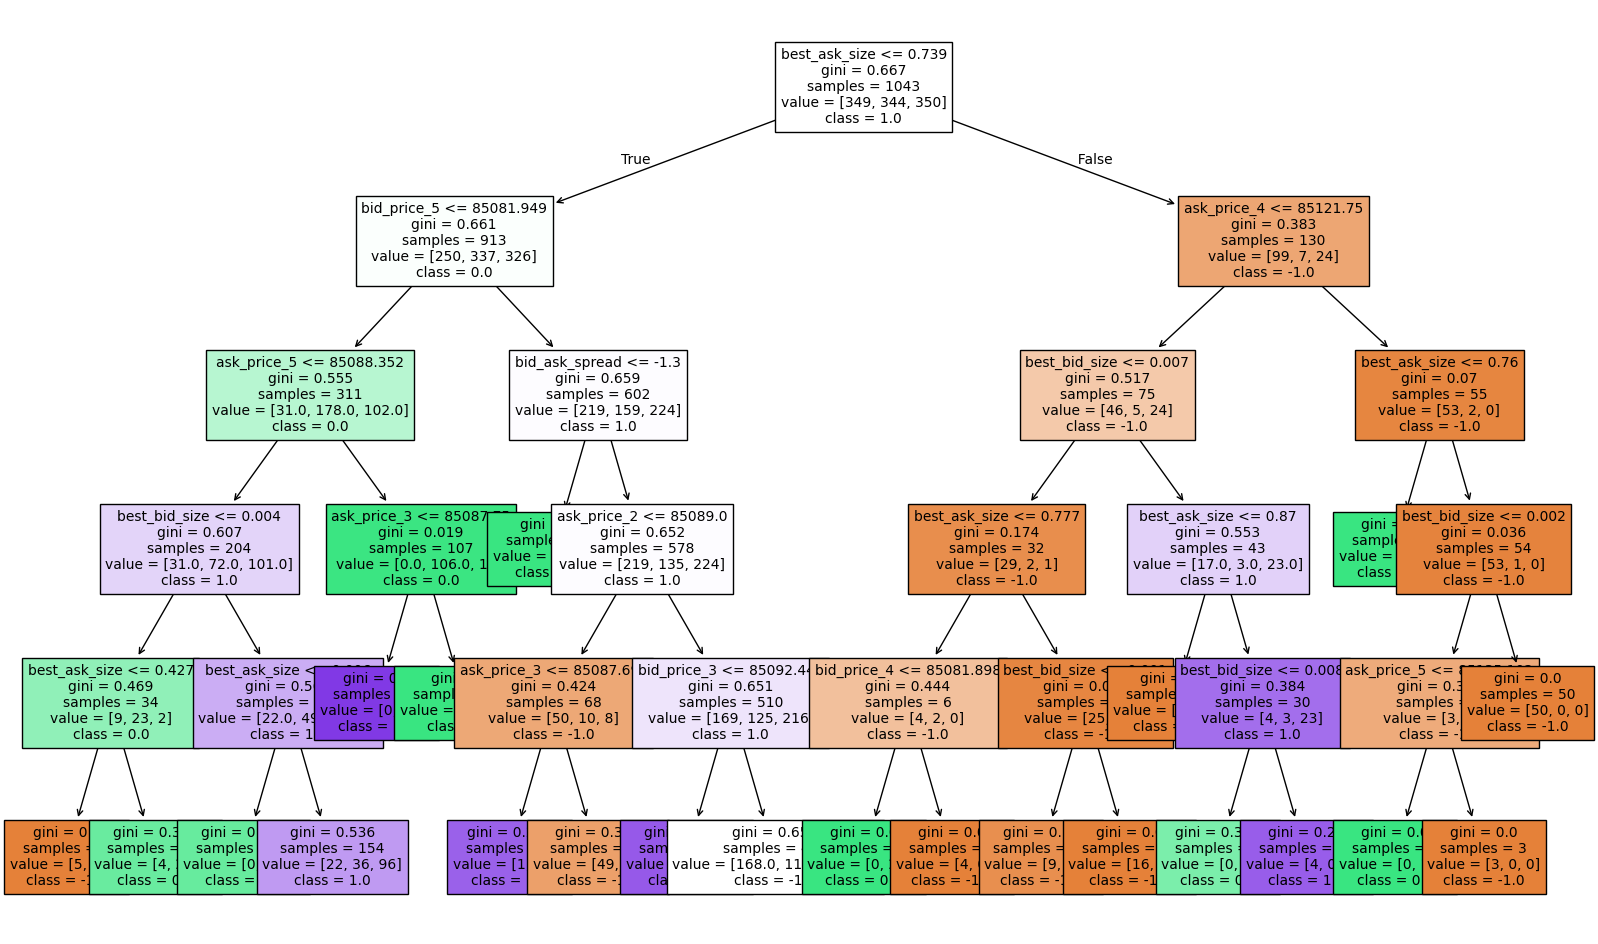

In [22]:
# 初始化決策樹分類器
clf_tree = tree.DecisionTreeClassifier(max_depth=5) # 可以調整 max_depth 來控制樹的複雜度
clf_tree.fit(X_train, y_train)

# 視覺化決策樹
plt.figure(figsize=(20, 12))
tree.plot_tree(clf_tree,
               filled=True,
               fontsize=10,
               feature_names=X.columns,
               class_names=[str(c) for c in clf_tree.classes_]) # 確保類別名稱是字串
plt.savefig('orderbook_tree.jpg')
plt.show()


In [23]:

# Evaluate the Decision Tree Classifier
tree_accuracy = clf_tree.score(X_test, y_test)
print('The test accuracy of Decision Tree Classifer: ', tree_accuracy)

The test accuracy of Decision Tree Classifer:  0.5747126436781609


In [26]:
# Initialize the AdaBoost Classifier
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42) 
adaboost_model.fit(X_train, y_train)

# Predict the AdaBoost Classifier
adaboost_predictions = adaboost_model.predict(X_test)

# Evaluate the AdaBoost Classifier
print("\nAdaBoost Classification Report:")
print(classification_report(y_test, adaboost_predictions))

# Get Adaboost Accuracy
adaboost_accuracy = adaboost_model.score(X_test, y_test)
print('The test accuracy of AdaBoost Classifer: ', adaboost_accuracy)


AdaBoost Classification Report:
              precision    recall  f1-score   support

        -1.0       0.67      0.64      0.66        92
         0.0       0.70      0.57      0.63        86
         1.0       0.59      0.73      0.66        83

    accuracy                           0.65       261
   macro avg       0.65      0.65      0.65       261
weighted avg       0.66      0.65      0.65       261

The test accuracy of AdaBoost Classifer:  0.6475095785440613


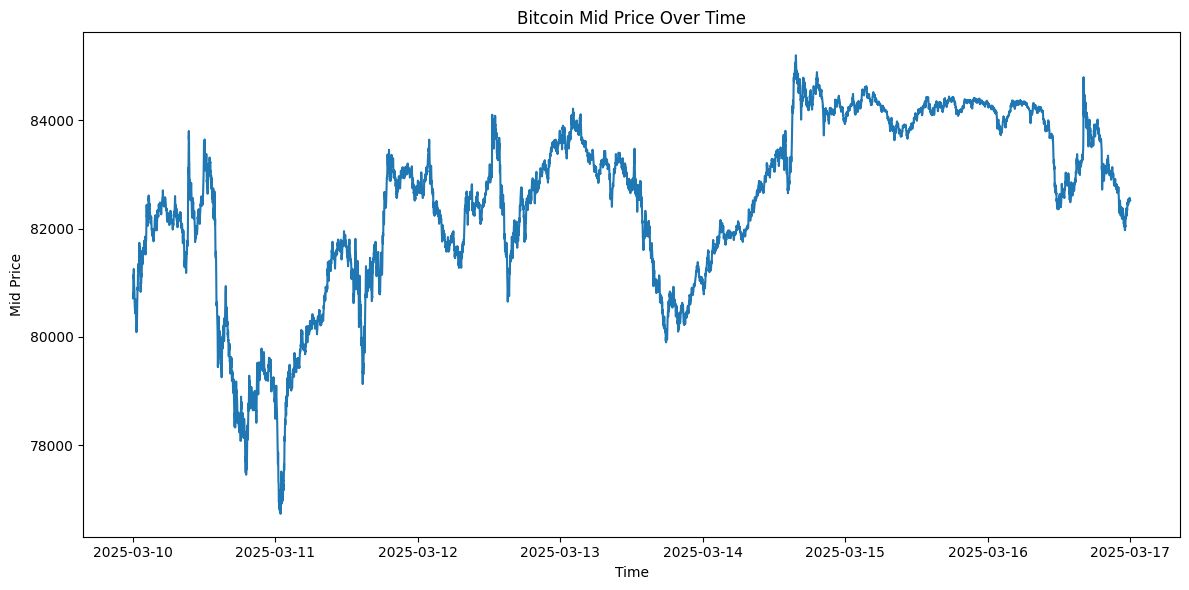

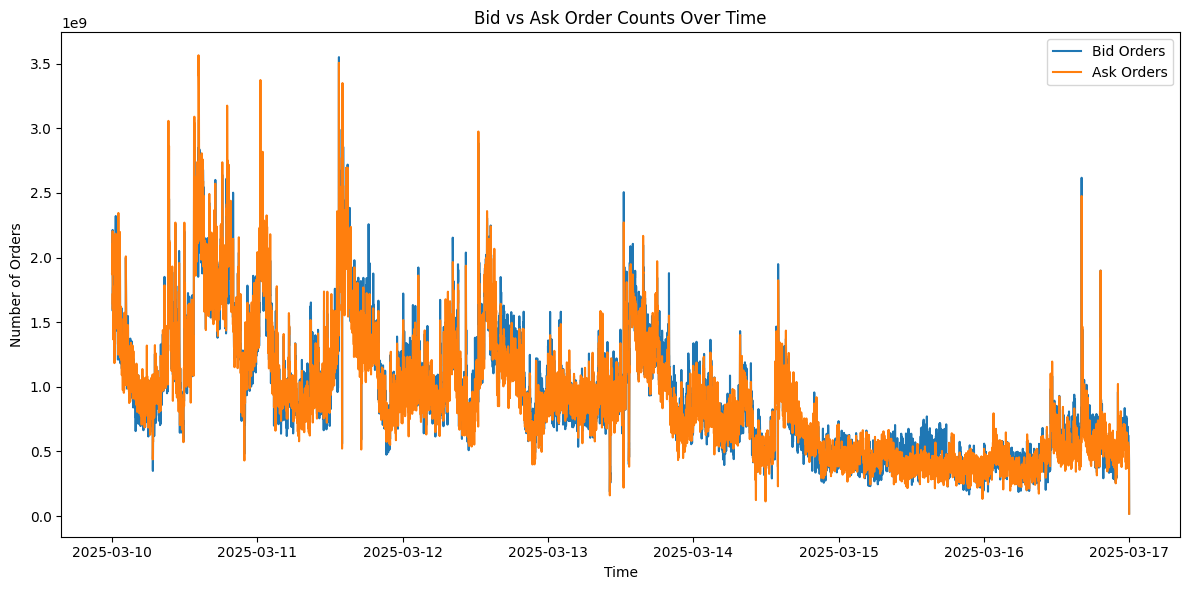

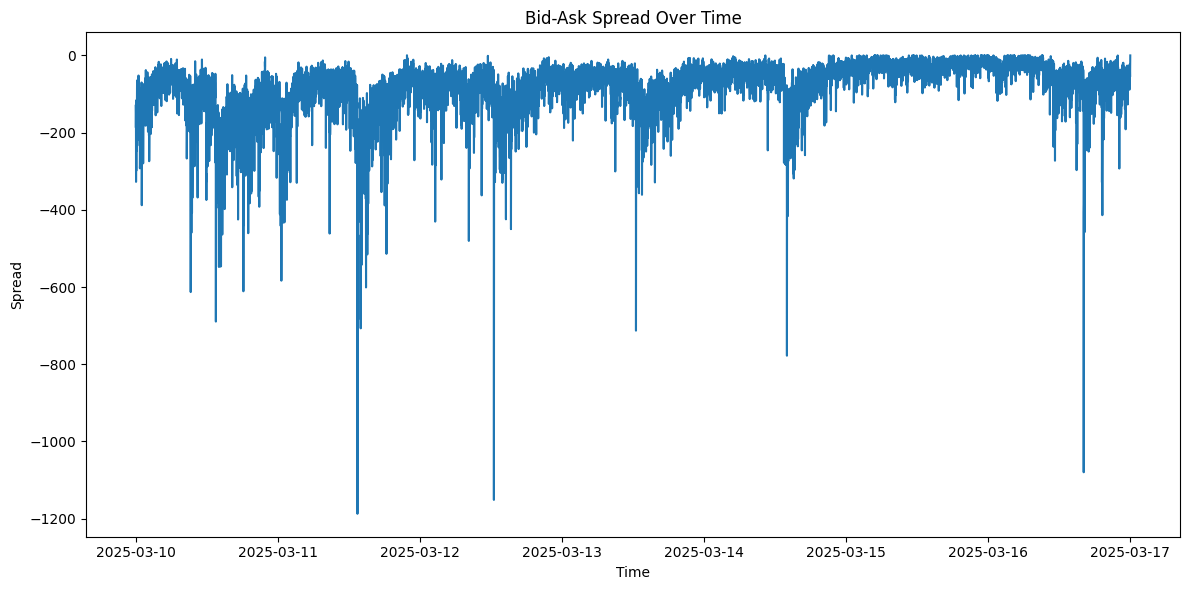

c:\Users\Tim Phan\Downloads\CDA_2025\src\tim\orderbook_analysis.py:84: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  d['rolling_max'] = d['mid_price'].rolling(f'{windowHours}H', min_periods=1).max()


             startTime             endTime  drop_pct        duration
0  2025-03-10 09:24:00 2025-03-10 10:23:00  0.020048 0 days 00:59:00
1  2025-03-10 09:24:00 2025-03-10 11:14:00  0.020236 0 days 01:50:00
2  2025-03-10 12:04:00 2025-03-10 13:52:00  0.021096 0 days 01:48:00
3  2025-03-10 21:39:00 2025-03-11 00:21:00  0.022347 0 days 02:42:00
4  2025-03-11 11:33:00 2025-03-11 14:04:00  0.021601 0 days 02:31:00
5  2025-03-11 11:33:00 2025-03-11 14:25:00  0.020530 0 days 02:52:00
6  2025-03-11 13:28:00 2025-03-11 14:56:00  0.021223 0 days 01:28:00
7  2025-03-12 01:54:00 2025-03-12 04:02:00  0.020382 0 days 02:08:00
8  2025-03-12 01:54:00 2025-03-12 04:09:00  0.020155 0 days 02:15:00
9  2025-03-12 01:54:00 2025-03-12 04:15:00  0.020469 0 days 02:21:00
10 2025-03-12 12:32:00 2025-03-12 13:57:00  0.020487 0 days 01:25:00
11 2025-03-12 12:32:00 2025-03-12 14:15:00  0.021914 0 days 01:43:00
12 2025-03-12 12:32:00 2025-03-12 14:23:00  0.020276 0 days 01:51:00
13 2025-03-12 12:32:00 2025-03-12 

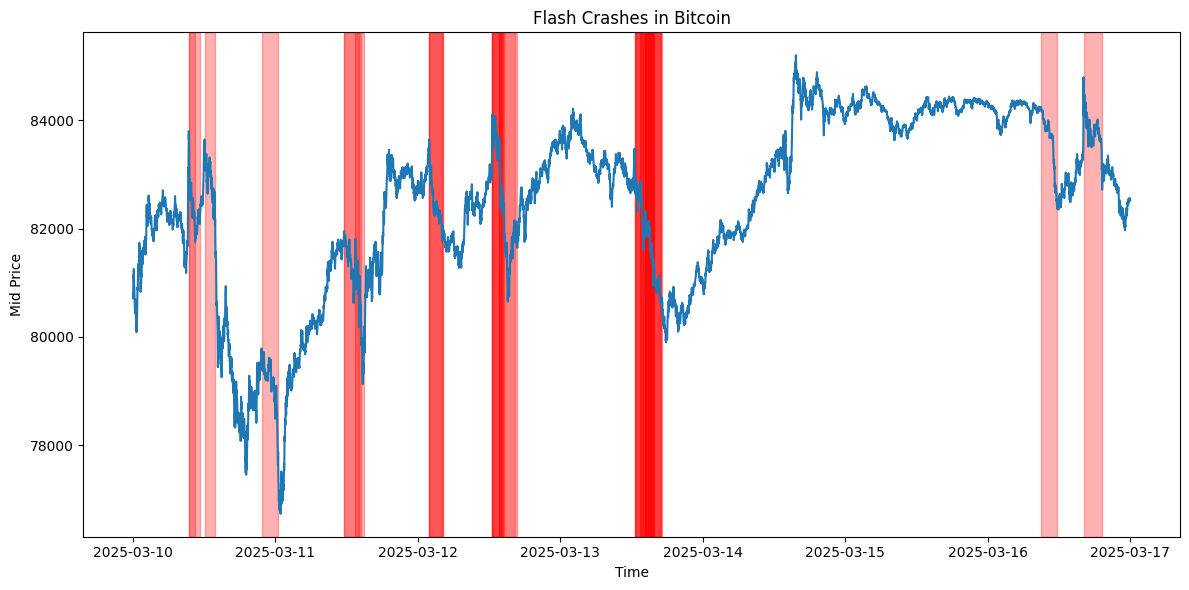

In [9]:
import importlib
import src.tim.orderbook_analysis as oba
importlib.reload(oba)

# load the preprocessed CSV
df = oba.loadOrderbookCsv("data/bitcoin_per_minute.csv")

# visualize
oba.plotMidPrice(df)
oba.plotOrderCounts(df)
oba.plotSpread(df)

# detect & inspect hourly flash crashes
crashes = oba.detectFlashCrashesHourly(df, thresholdPct=0.02, windowHours=3)
print(crashes)
oba.plotFlashCrashes(df, crashes)


In [24]:
import numpy as np
import random
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import src.tim.orderbook_analysis as oba

# ─── Reproducibility ─────────────────────────────────────
np.random.seed(42)
random.seed(42)

# ─── 1) Load & label ──────────────────────────────────────
df = oba.loadOrderbookCsv("data/bitcoin_per_minute.csv")
crashes = oba.detectFlashCrashesHourly(df, thresholdPct=0.02, windowHours=3)
df['in_crash_window'] = 0
for ct in crashes['startTime']:
    mask = (df.index < ct) & (df.index >= ct - pd.Timedelta(hours=3))
    df.loc[mask, 'in_crash_window'] = 1

# ─── 2) Feature engineering ───────────────────────────────
df['spread']    = df['best_ask'] - df['best_bid']
df['imbalance'] = (df['bid_orders'] - df['ask_orders']) / (df['bid_orders'] + df['ask_orders'])

# add some lags
for lag in [1,5,15]:
    df[f'ask_lag_{lag}']       = df['ask_orders'].shift(lag)
    df[f'imbalance_lag_{lag}'] = df['imbalance'].shift(lag)

# rolling volatility of imbalance
df['imb_std_5'] = df['imbalance'].rolling(5).std()

features = [
    'ask_orders','spread','imbalance',
    'ask_lag_1','ask_lag_5','ask_lag_15',
    'imbalance_lag_1','imbalance_lag_5','imbalance_lag_15',
    'imb_std_5'
]
df = df.dropna(subset=features + ['in_crash_window'])

X = df[features]
y = df['in_crash_window']

# ─── 3) Chronological train/test split ───────────────────
split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# ─── 4) Train Random Forest ──────────────────────────────
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# ─── 5) Evaluate ─────────────────────────────────────────
y_pred = rf.predict(X_test)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

           0     0.8212    0.9994    0.9016      1654
           1     0.0000    0.0000    0.0000       360

    accuracy                         0.8208      2014
   macro avg     0.4106    0.4997    0.4508      2014
weighted avg     0.6744    0.8208    0.7404      2014

Confusion Matrix:
 [[1653    1]
 [ 360    0]]


In [22]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

probs = rf.predict_proba(X_test)[:,1]

for thresh in [0.01, 0.03, 0.05, 0.00001, 0.2]:
    y_pred = (probs > thresh).astype(int)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred)
    print(f"threshold={thresh:>5} → precision={prec:.3f}, recall={rec:.3f}")


threshold= 0.01 → precision=0.440, recall=0.770
threshold= 0.03 → precision=0.464, recall=0.689
threshold= 0.05 → precision=0.483, recall=0.645
threshold=1e-05 → precision=0.418, recall=0.861
threshold=  0.2 → precision=0.538, recall=0.411
